### Load in

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandorasim as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time
from tqdm import tqdm
from pandorasim.utils import plot_nirda_integrations
from matplotlib.patches import Rectangle
from astropy.io import fits

### Define Functions

In [4]:
### function for plotting a subarray - this should eventually be replaced by .get_FFIs and .plot_FFIs 

# .get_FFIs and .plot_FFIs may eventually allow us to select targets and subarray shapes. 
# right now they extract the brightest targets with a pre-determined subarray size

def plot_centered_box(center, width, height, ax=None, **kwargs):
    """
    Plot a 2D box centered at the given point with the given width and height.

    Parameters:
    - center: Tuple (x, y) representing the center point of the box.
    - width: Width of the box.
    - height: Height of the box.
    - ax: Axes object to plot on. If None, creates a new figure and axes.
    - kwargs: Additional keyword arguments to be passed to matplotlib.patches.Rectangle.

    Returns:
    - ax: Axes object with the box plotted.
    """
    if ax is None:
        ax = plt.gca()
    
    # Convert quantities to floats if necessary
    if hasattr(center[0], 'magnitude'):
        center = (center[0].magnitude, center[1].magnitude)
        width = width.magnitude
        height = height.magnitude
    
    # Calculate the coordinates of the box
    x_left = center[0] - width / 2
    y_bottom = center[1] - height / 2
    
    # Create a Rectangle patch
    box = Rectangle((x_left, y_bottom), width, height, **kwargs)
    
    # Add the Rectangle patch to the axes
    ax.add_patch(box)
    
    return ax

In [5]:
### This is a function for identifying additional targets in the frame. -- we can adjust based on target criteria

# The simulator has the function .get_FFIs() that finds the 8 brightest targets in addition to our central target. 
# Eventually, that function may allow us to specify how many targets we want, and we may be able to use that.

def find_target_indices(cat):
    
    # Convert the filtered DataFrame column to a dictionary
    arr = cat['mag']
    indices = arr.to_dict()
    
    # Sort the dictionary based on values (numbers) and get the first 20 elements
    # NOTE: list out more if you need more targets
    sorted_indices = sorted(indices, key=lambda x: indices[x])[:100] 
    
    good=[]
    for i in range(len(sorted_indices)):
        if cat['ruwe'][i] < 1.2 and cat['mag'][i] < 15.:
            good.append(sorted_indices[i]) 
    
    return good

# Obs Data Volume

In [6]:
### One observation, long duration (about one orbit), full VISDA array, no NIRDA

# NOTE - we could reduce Gbits and downlink time by reducing temporal resolution, 
#        e.g., only save every other integration, or every 3 integrations

data_rate             = 5 #Mbps
VIS_xpix              = 200 #only taking part of the image
VIS_ypix              = 200 
regions               = 3  
bits_per_pix          = 32
frame_time            = 0.2 #sec
stored_frames_per_int = 1
frames_per_int        = 1
num_int               = 30000 
compression_fractor   = 3
int_and_reset_time    = frame_time * frames_per_int
bits_per_int          = VIS_xpix * VIS_ypix * regions * bits_per_pix * stored_frames_per_int
bits_per_sec          = bits_per_int / int_and_reset_time
test_time             = num_int * int_and_reset_time  #seconds
bits_per_sec_comp     = bits_per_sec / compression_fractor
bits_test_total       = bits_per_sec_comp * test_time
Gbits_test_packet     = bits_test_total / 1E9 * 1.1 * 1.25
downlinks             = Gbits_test_packet * 1E9 / (data_rate * 1E6) /60 /8  #assuming 8 min passes

print('test time:', test_time/60/60, 'hours')
print(Gbits_test_packet, 'Gbits')
print(downlinks, 'downlinks')

print('.')
print('.')
print('.')

### If reduced temporal resolution
reduce_by = 2
print('Reduced Temporal Resolution')
print(Gbits_test_packet/reduce_by, 'Gbits')
print(downlinks/reduce_by, 'downlinks')

test time: 1.6666666666666667 hours
52.800000000000004 Gbits
22.000000000000004 downlinks
.
.
.
Reduced Temporal Resolution
26.400000000000002 Gbits
11.000000000000002 downlinks


### Integration Scheme

# Define Target 

In [7]:
### Primary target
target = ps.Target.from_gaia("GJ 436")

### Set Observation Parameters
# define center based on primary target
ra = target.ra
dec = target.dec
theta = 0*u.deg

# define observation duration
duration = test_time * u.s #adding unit seconds
obstime = Time(target.planets['b']['pl_tranmid'].value - (duration/2).to(u.day).value, format='jd') #arbitrary time


### Initialize Observatory and Point
p = ps.PandoraSim(ra=ra, dec=dec, theta=theta, duration=duration, obstime=obstime)

### Set up Sky Catalog
cat = p.SkyCatalog

In [8]:
### Find additional targets
targs = find_target_indices(cat)
print("Indices of possible tagets in frame:", targs)

Indices of the brightest stars in frame: [169, 128, 178, 140, 31, 1, 159, 7, 144, 35, 70, 121, 8, 22]


In [9]:
### Pick additional targets & print out their info
# NOTE: for now, selecting 3 targets, but we can select more

print('Primary Target')
print('j magnitude:', target.jmag)

target2 = 88
print('.')
print('.')
print('Target 2')
print('J magnitude:', cat['jmag'][target2])

target3 = 140
print('.')
print('.')
print('Target 3')
print('J magnitude:', cat['jmag'][target3])

Primary Target
j magnitude: 6.9
.
.
Target 2
J magnitude: 13.522000312805176
.
.
Target 3
J magnitude: 12.920000076293945


# Observation

In [10]:
### Set up VIS observation
visda = p.VISDA

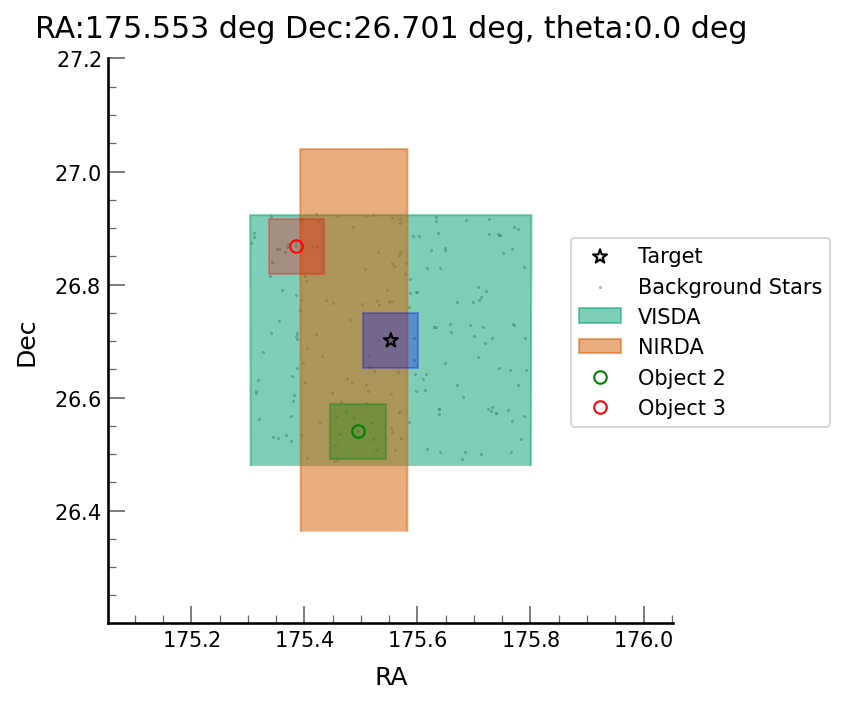

In [11]:
### Map target on expected location on detector
fig = p.plot_footprint();

### idenitfy regions to save
region = [200,200]
box_width = (region[0]/2048)
box_height = (region[1]/2048)

### plot targets
# central target
center_point = (ra.value, dec.value)
plot_centered_box(center_point, box_width, box_height, ax=plt.gca(), color='blue', alpha=0.3)

# object 2 - can select other indices in brightest[] to find a spread on detector
center_point = (cat['ra'][target2], cat['dec'][target2])
plot_centered_box(center_point, box_width, box_height, ax=plt.gca(), color='green', alpha=0.3)
plt.plot(cat['ra'][target2], cat['dec'][target2], 'o', label='Object 2', markerfacecolor='none', markeredgecolor='green')

# object 3 - can select other indices in brightest[] to find a spread on detector
center_point = (cat['ra'][target3], cat['dec'][target3])
plot_centered_box(center_point, box_width, box_height, ax=plt.gca(), color='red', alpha=0.3)
plt.plot(cat['ra'][target3], cat['dec'][target3], 'o', label='Object 3', markerfacecolor='none', markeredgecolor='red')


### other plotting things
plt.legend(bbox_to_anchor=(0.8, 0.7))
plt.show()

# NOTE: this is showing the full VISDA, and a subarray of NIRDA (I think). We don't need NIRDA for this. 

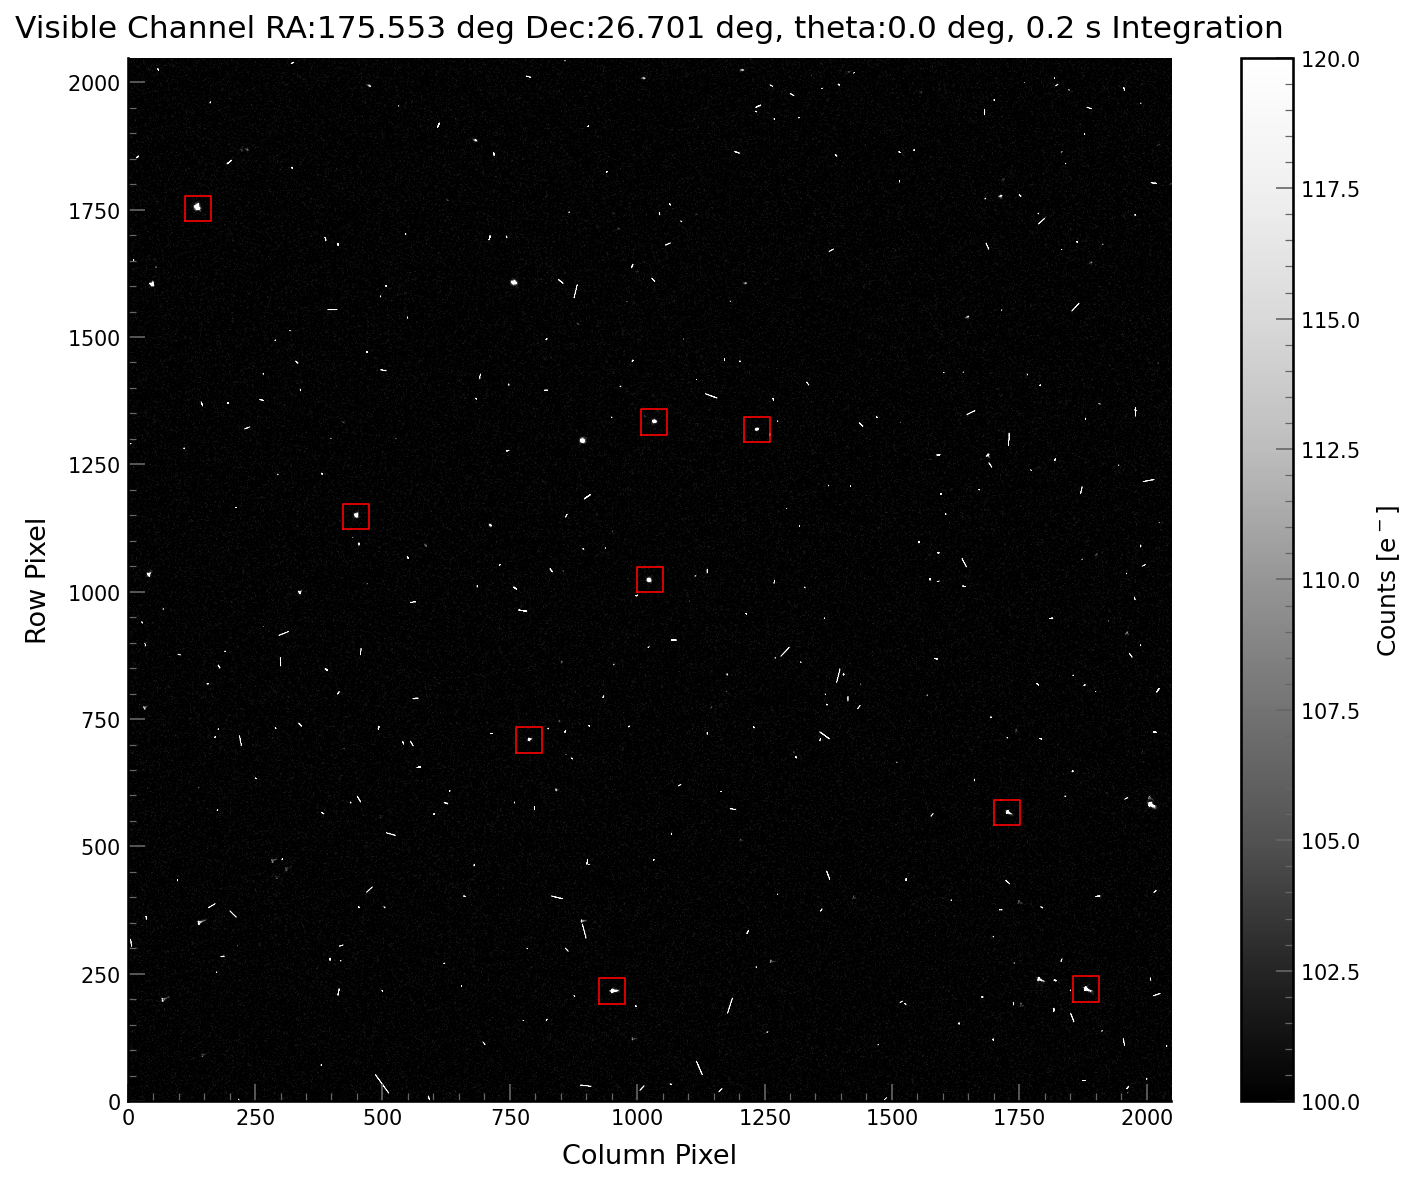

In [12]:
### Create and plot a simulated observation using plot_FFI

# nframes : Number of FFI frames to generate.
# nreads : Number of reads of the detector to coadd in each frame.

### NOTE: FFI functions don't allow us to specify targets and subarray sizes yet. 
###       Right now, we just have 8 small subarrays around bright targets. 
### NOTE: This takes a long time to run!!! Because there are so many integrations. 
###       The kernel dies if you do all 30000, so we are saving less for now.


p.get_FFIs(nreads=stored_frames_per_int, nframes=int(num_int/100), include_noise=True, include_cosmics=True, make_subarrays=True)
p.plot_FFI(nreads=1, include_noise=True, include_cosmics=True, subarrays=True);

### Sim Output Fits Files

In [21]:
### Produce simulated output file of the regions of interest (rois)

# NOTE: outfile sizes don't match the data volume spreadsheet, but I can answer why once I chat about file formatting details
# NOTE: this will update once we update the FFI functions above

# Remember to update the fits file title for 3.12 or 3.17
rois_outfile = '3_12_rois.fits' #'3_17_rois.fits'
p.save_visda(outfile=rois_outfile, rois=True)

In [25]:
### Show what is in our fits file: 

# Three FITS file extensions: 
#    (1) PRIMARY: information about the simulated observation 
#    (2) SCIENCE: data info, images
#    (3) ROITABLE: VISDA pixel coordinates of the origin of the subarray, which is defined as the lower left corner

hdul_rois = fits.open(rois_outfile)
print(hdul_rois.info())
print('.')
print('.')
print('.')
print('-- PRIMARY Headers --')
print(hdul_rois[0].header)
print('.')
print('.')
print('.')
print('-- SCIENCE Headers --')
print(hdul_rois[1].header)
print('.')
print('.')
print('.')
print('-- ROITABLE Headers --')
print(hdul_rois[2].header)

Filename: 3_12_rois.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  SCIENCE       1 ImageHDU        12   (153, 150, 300)   int64   
  2  ROITABLE      1 BinTableHDU     22   9R x 2C   [K, K]   
None
.
.
.
-- PRIMARY Headers --
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  EXTNAME = 'PRIMARY '           / name of extension                              NEXTEND =                    2 / number of standard extensions                  SIMDATA =                    T / simulated data                                 SCIDATA =                    F / science data                                   TELESCOP= 'NASA Pandora'       / telescope                

# Check pass threshold

The data should measure the pointing accuracy (absolute) and precision (rms variation from nominal) in arcseconds over TBD time. Compare each image integration to the steady model and record variation in x, y, z.

In [26]:
### Steady model / expected target locations:

print('Primary Target')
print('coordinates (ra, dec):', target.ra, ', ', target.dec)
loc_y_1 = cat['vis_row'][0]
loc_x_1 = cat['vis_column'][0] 
print('expected pixel location on detector:', loc_x_1, ', ', loc_y_1) 
print('.')
print('.')
print('.')

print('Target 2')
print('coordinates (ra, dec):', cat['ra'][target2], ', ', cat['dec'][target2])
### calculate location on detector
loc_y_2 = cat['vis_row'][target2]
loc_x_2 = cat['vis_column'][target2] 
print('expected pixel location on detector:', loc_x_2, ', ', loc_y_2) 
print('.')
print('.')
print('.')

print('Target 3')
print('coordinates (ra, dec):', cat['ra'][target3], ', ', cat['dec'][target3])
### calculate location on detector
loc_y_3 = cat['vis_row'][target3] 
loc_x_3 = cat['vis_column'][target3]
print('expected pixel location on detector:', loc_x_3, ', ', loc_y_3) 


Primary Target
coordinates (ra, dec): 175.55296206120474 deg ,  26.701097264563185 deg
expected pixel location on detector: 1022.9999999998095 ,  1022.999848647419
.
.
.
Target 2
coordinates (ra, dec): 175.49488160615823 ,  26.540574610474543
expected pixel location on detector: 1262.7201636540535 ,  274.1479364288637
.
.
.
Target 3
coordinates (ra, dec): 175.38574391394636 ,  26.86739460234275
expected pixel location on detector: 1712.1596854413297 ,  1775.8812297202037


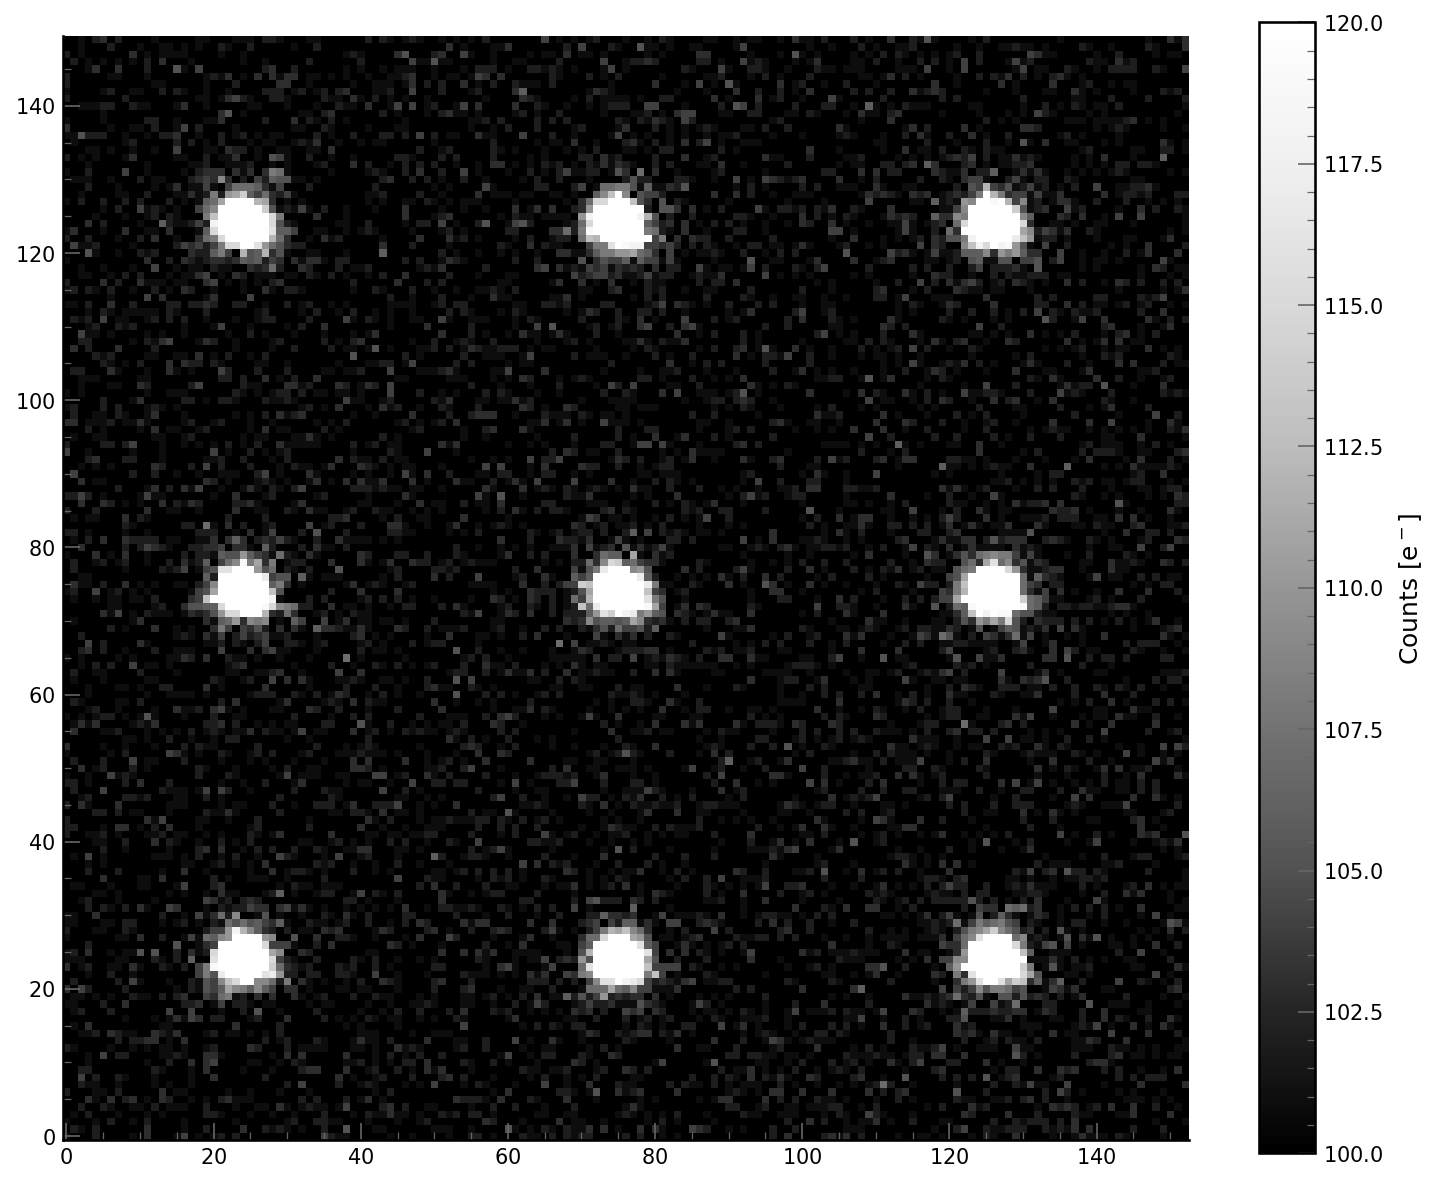

In [27]:
### Plot the subarrays from the fits file to compare to expected target locations

### NOTE: not currently our actual targets and subarrays, 
###       but once eventually we can compary these subarray images to expected target locations

frame = 0 # specify which integration to plot - can plot different integrations to see any possible jitter

with plt.style.context(ps.PANDORASTYLE):
    vmin = p.VISDA.bias.value
    vmax = p.VISDA.bias.value + 20
    cmap = "Greys_r"
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(
        hdul_rois[1].data[frame],
        origin="lower",
        # origin = 'upper',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        # **kwargs,
    )
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Counts [e$^-$]", fontsize=12);